<a href="https://colab.research.google.com/github/zzeng507/sec-financial-analysis/blob/main/edgar-finance-pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# ===== Cell 0: Setup =====
!pip -q install yfinance scikit-learn

import re, time, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import yfinance as yf

plt.rcParams["figure.figsize"] = (8,4)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

NAME  = "ZIQI_ZENG"
EMAIL = "zzeng507@gmail.com"

SEC_HEADERS = {
    "User-Agent": f"{NAME} {EMAIL}",
    "Accept-Encoding": "gzip, deflate",
    "Accept": "application/json",
    "Host": "data.sec.gov",
}


In [15]:
# ===== Cell 1: Peer selection & CIKs =====
# You can change to e.g. ["TSLA","NVDA","F"] or ["WMT","COST","TGT"]
TICKERS = ["TSLA", "NVDA", "F"]
YEARS_WINDOW = 5

# Fallback CIKs (extend if you change TICKERS)
FALLBACK_CIKS = {
    "TSLA":"0001318605","NVDA":"0001045810","F":"0000037996",
    "WMT":"0000104169","COST":"0000909832","TGT":"0000027419",
    "AAPL":"0000320193","MSFT":"0000789019","GM":"0000040730"
}

# Build ticker → CIK dict (using fallback; robust enough for this project)
CIKS = {t: FALLBACK_CIKS[t] for t in TICKERS}
CIKS


{'TSLA': '0001318605', 'NVDA': '0001045810', 'F': '0000037996'}

In [16]:
# ===== Cell 2: EDGAR helpers =====
ANNUAL_FORMS = {"10-K","10-K/A","20-F","20-F/A"}
BASE_FACTS = "https://data/sec.gov/api/xbrl/companyfacts/CIK{cik}.json".replace("data/", "data.")  # ensure correct host

EXCLUDE_PATTERNS = [
    r"DeferredRevenue", r"ContractWithCustomer", r"RevenueRecognized",
    r"IncreaseDecreaseInDeferredRevenue", r"ProFormaRevenue",
    r"Geographic.*Revenue", r"Regulated.*Revenue"
]
_exclude_re = re.compile("|".join(EXCLUDE_PATTERNS), re.I)

def fetch_companyfacts(cik: str) -> dict:
    time.sleep(0.25)  # be polite
    r = requests.get(BASE_FACTS.format(cik=cik), headers=SEC_HEADERS, timeout=60)
    r.raise_for_status()
    return r.json()

def infer_year(rec: dict):
    if rec.get("fy"):
        return int(rec["fy"])
    frame = rec.get("frame") or ""
    m = re.search(r"(?:FY|CY)?(\d{4})", frame)
    if m: return int(m.group(1))
    end = rec.get("end") or ""
    if len(end) >= 4 and end[:4].isdigit(): return int(end[:4])
    return None

def pick_records(records):
    items=[]
    for r in records:
        fy = infer_year(r)
        if fy and (r.get("val") is not None):
            rr = dict(r); rr["fy"] = fy
            items.append(rr)
    if not items: return []
    best={}
    for r in items:
        fy = int(r["fy"]); form=r.get("form"); end=r.get("end") or ""
        score = (1 if form in ANNUAL_FORMS else 0, end)  # prefer annual & latest end
        if (fy not in best) or (score > best[fy]["_score"]):
            best[fy] = {"fy":fy,"val":float(r["val"]), "form":form, "end":end, "_score":score}
    return sorted([{"fy":v["fy"],"val":v["val"],"form":v["form"],"end":v["end"]} for v in best.values()],
                  key=lambda x:x["fy"])

def extract_units_generic(units_dict):
    if "USD" in units_dict: return pick_records(units_dict["USD"])
    for _, v in units_dict.items():
        if isinstance(v, list): return pick_records(v)
    return None

def autodetect_revenue_key(facts: dict):
    """
    Scan all us-gaap keys; pick the 'Revenue/Sales' key with most annual points, excluding deferred/recognized, etc.
    """
    best_key, best_recs = None, []
    usgaap = facts.get("facts", {}).get("us-gaap", {})
    for key, detail in usgaap.items():
        name = str(key)
        if (("Revenue" in name) or ("Sales" in name)) and (not _exclude_re.search(name)):
            units = detail.get("units", {})
            recs = extract_units_generic(units) or []
            if len(recs) > len(best_recs):
                best_recs, best_key = recs, name
    return best_key, best_recs


In [17]:
# ===== Cell 3: Keys & extract helpers =====

# Core statement keys
CORE_KEYS = {
    "Revenue":            ("auto", "Revenue"),  # filled by auto-detect; keep placeholder
    "NetIncome":          ("us-gaap","NetIncomeLoss"),
    "Assets":             ("us-gaap","Assets"),
    "Liabilities":        ("us-gaap","Liabilities"),
    "Equity":             ("us-gaap","StockholdersEquity"),
    "CurrentAssets":      ("us-gaap","AssetsCurrent"),
    "CurrentLiabilities": ("us-gaap","LiabilitiesCurrent"),
    "GrossProfit":        ("us-gaap","GrossProfit"),
}

# Advanced fields for FCF/EBITDA/PE
ADV_KEYS = {
    # Cash flow (FCF = CFO - CapEx)
    "CFO": [
        ("us-gaap","NetCashProvidedByUsedInOperatingActivities"),
        ("us-gaap","NetCashProvidedByUsedInOperatingActivitiesContinuingOperations"),
    ],
    "CapEx": [
        ("us-gaap","PaymentsToAcquirePropertyPlantAndEquipment"),
        ("us-gaap","CapitalExpenditures"),
    ],
    # EBITDA ≈ OperatingIncome + D&A  (fallback to NI + Tax + Interest + D&A)
    "OperatingIncome": [
        ("us-gaap","OperatingIncomeLoss")
    ],
    "DepAmort": [
        ("us-gaap","DepreciationAndAmortization"),
        ("us-gaap","DepreciationDepletionAndAmortization"),
    ],
    "InterestExpense": [
        ("us-gaap","InterestExpense")
    ],
    "IncomeTaxExpense": [
        ("us-gaap","IncomeTaxExpenseBenefit")
    ],
    # EPS / Shares for PE
    "DilutedShares": [
        ("us-gaap","WeightedAverageNumberOfDilutedSharesOutstanding"),
        ("us-gaap","CommonStockSharesOutstanding")
    ]
}

def extract_first_available(facts: dict, candidates: list):
    for ns, key in candidates:
        detail = facts.get("facts",{}).get(ns,{}).get(key)
        if not detail:
            continue
        recs = extract_units_generic(detail.get("units", {})) or []
        if recs:
            return recs, f"{ns}:{key}"
    return [], None

def get_financials_autorev(ticker: str, cik: str):
    facts = fetch_companyfacts(cik)
    rows={}
    chosen = {}

    # Auto-detect Revenue
    rev_key, rev_recs = autodetect_revenue_key(facts)
    if rev_recs:
        chosen["Revenue"] = f"us-gaap:{rev_key}"
        for r in rev_recs:
            fy, val = r["fy"], r["val"]
            rows.setdefault(fy, {"Ticker": ticker, "Year": fy})
            rows[fy]["Revenue"] = val

    # Core metrics
    for m,(ns2,k2) in CORE_KEYS.items():
        if ns2 == "auto":  # skip placeholder
            continue
        detail = facts.get("facts",{}).get(ns2,{}).get(k2)
        if not detail:
            continue
        recs = extract_units_generic(detail.get("units", {})) or []
        for r in recs:
            fy, val = r["fy"], r["val"]
            rows.setdefault(fy, {"Ticker": ticker, "Year": fy})
            rows[fy][m] = val

    # Advanced fields
    for m, cand in ADV_KEYS.items():
        recs, used_key = extract_first_available(facts, cand)
        if recs:
            chosen[m] = used_key
            for r in recs:
                fy, val = r["fy"], r["val"]
                rows.setdefault(fy, {"Ticker": ticker, "Year": fy})
                rows[fy][m] = val

    df = pd.DataFrame(list(rows.values())).sort_values("Year") if rows else pd.DataFrame()
    return df, chosen


In [18]:
# ===== Cell 4: Build dataset =====
frames, chosen_map = [], {}
for t in TICKERS:
    df_t, chosen = get_financials_autorev(t, CIKS[t])
    df_t["Ticker"] = t
    frames.append(df_t)
    chosen_map[t] = chosen

raw_df = pd.concat(frames, ignore_index=True)
max_year = int(raw_df["Year"].max())
keep_years = list(range(max_year - YEARS_WINDOW + 1, max_year + 1))
raw_df = raw_df[raw_df["Year"].isin(keep_years)].sort_values(["Ticker","Year"]).reset_index(drop=True)

print("Chosen keys per ticker (including Revenue):")
for k,v in chosen_map.items():
    print(k, "→", v)
raw_df.head(12)


Chosen keys per ticker (including Revenue):
TSLA → {'Revenue': 'us-gaap:CostOfRevenue', 'CFO': 'us-gaap:NetCashProvidedByUsedInOperatingActivities', 'CapEx': 'us-gaap:PaymentsToAcquirePropertyPlantAndEquipment', 'OperatingIncome': 'us-gaap:OperatingIncomeLoss', 'DepAmort': 'us-gaap:DepreciationAndAmortization', 'InterestExpense': 'us-gaap:InterestExpense', 'IncomeTaxExpense': 'us-gaap:IncomeTaxExpenseBenefit', 'DilutedShares': 'us-gaap:WeightedAverageNumberOfDilutedSharesOutstanding'}
NVDA → {'Revenue': 'us-gaap:CostOfRevenue', 'CFO': 'us-gaap:NetCashProvidedByUsedInOperatingActivities', 'CapEx': 'us-gaap:PaymentsToAcquirePropertyPlantAndEquipment', 'OperatingIncome': 'us-gaap:OperatingIncomeLoss', 'DepAmort': 'us-gaap:DepreciationAndAmortization', 'InterestExpense': 'us-gaap:InterestExpense', 'IncomeTaxExpense': 'us-gaap:IncomeTaxExpenseBenefit', 'DilutedShares': 'us-gaap:WeightedAverageNumberOfDilutedSharesOutstanding'}
F → {'Revenue': 'us-gaap:Revenues', 'CFO': 'us-gaap:NetCashProvi

,Ticker,Year,Revenue,NetIncome,Assets,Liabilities,Equity,CurrentAssets,CurrentLiabilities,GrossProfit,CFO,CapEx,OperatingIncome,DepAmort,InterestExpense,IncomeTaxExpense,DilutedShares
0,F,2022,"158,057,000,000.00",NaN,"255,884,000,000.00","212,717,000,000.00","43,242,000,000.00","116,476,000,000.00","96,866,000,000.00",NaN,"6,853,000,000.00",NaN,"6,276,000,000.00","7,674,000,000.00","4,593,000,000.00","-864,000,000.00","4,014,000,000.00"
1,F,2023,"176,191,000,000.00","4,347,000,000.00","273,310,000,000.00","230,512,000,000.00","42,773,000,000.00","121,481,000,000.00","101,531,000,000.00",NaN,"14,918,000,000.00",NaN,"5,458,000,000.00","7,690,000,000.00","7,613,000,000.00","-362,000,000.00","4,041,000,000.00"
2,F,2024,"184,992,000,000.00","5,879,000,000.00","285,196,000,000.00","240,338,000,000.00","44,835,000,000.00","124,474,000,000.00","106,859,000,000.00",NaN,"15,423,000,000.00",NaN,"5,219,000,000.00","7,567,000,000.00",NaN,"1,339,000,000.00","4,021,000,000.00"
3,F,2025,NaN,"-36,000,000.00","292,725,000,000.00","247,644,000,000.00","45,057,000,000.00","126,612,000,000.00","114,988,000,000.00",NaN,"9,996,000,000.00",NaN,"830,000,000.00","3,747,000,000.00",NaN,"718,000,000.00","4,018,000,000.00"
4,NVDA,2022,"9,439,000,000.00","9,752,000,000.00","44,187,000,000.00","17,575,000,000.00","26,612,000,000.00","28,829,000,000.00","4,335,000,000.00","17,475,000,000.00","9,108,000,000.00",NaN,"10,041,000,000.00","567,000,000.00","236,000,000.00","189,000,000.00","2,535,000,000.00"
5,NVDA,2023,"11,618,000,000.00","4,368,000,000.00","41,182,000,000.00","19,081,000,000.00","22,101,000,000.00","23,073,000,000.00","6,563,000,000.00","15,356,000,000.00","5,641,000,000.00",NaN,"4,224,000,000.00",NaN,"262,000,000.00","-187,000,000.00","2,507,000,000.00"
6,NVDA,2024,"16,621,000,000.00","29,760,000,000.00","65,728,000,000.00","22,750,000,000.00","42,978,000,000.00","44,345,000,000.00","10,631,000,000.00","44,301,000,000.00","28,090,000,000.00",NaN,"32,972,000,000.00",NaN,"257,000,000.00","4,058,000,000.00","2,494,000,000.00"
7,NVDA,2025,"32,639,000,000.00","72,880,000,000.00","111,601,000,000.00","32,274,000,000.00","79,327,000,000.00","80,126,000,000.00","18,047,000,000.00","97,858,000,000.00","64,089,000,000.00",NaN,"81,453,000,000.00",NaN,"64,000,000.00","11,146,000,000.00","24,804,000,000.00"
8,NVDA,2026,"30,284,000,000.00","45,197,000,000.00","140,740,000,000.00","40,609,000,000.00","100,131,000,000.00","102,219,000,000.00","24,257,000,000.00","60,521,000,000.00","42,779,000,000.00",NaN,"50,078,000,000.00",NaN,NaN,"7,920,000,000.00","24,571,000,000.00"
9,TSLA,2022,"60,609,000,000.00","12,556,000,000.00","82,338,000,000.00","36,440,000,000.00","44,704,000,000.00","40,917,000,000.00","26,709,000,000.00","20,853,000,000.00","14,724,000,000.00","7,158,000,000.00","13,656,000,000.00",NaN,"191,000,000.00","1,132,000,000.00","3,475,000,000.00"


In [19]:
# ===== Cell 5: Advanced metrics & extras =====

def compute_ratios_advanced(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    eps = 1e-9

    # Base set
    df["ROE"] = df["NetIncome"] / (df["Equity"] + eps)
    df["ROA"] = df["NetIncome"] / (df["Assets"] + eps)
    df["GrossMargin"] = df.get("GrossProfit", np.nan) / (df.get("Revenue", np.nan) + eps)
    df["DebtToEquity"] = df["Liabilities"] / (df["Equity"] + eps)
    df["CurrentRatio"] = df["CurrentAssets"] / (df["CurrentLiabilities"] + eps)
    df["RevenueGrowth"] = df.groupby("Ticker")["Revenue"].pct_change()
    df["NetIncomeGrowth"] = df.groupby("Ticker")["NetIncome"].pct_change()

    # EBITDA (primary: OperatingIncome + DepAmort; fallback: NI + tax + interest + D&A)
    df["EBITDA"] = np.where(
        df.get("OperatingIncome", pd.Series([np.nan]*len(df))).notna() &
        df.get("DepAmort", pd.Series([np.nan]*len(df))).notna(),
        df["OperatingIncome"] + df["DepAmort"],
        df.get("NetIncome", 0).fillna(0)
        + df.get("IncomeTaxExpense", 0).fillna(0)
        + df.get("InterestExpense", 0).fillna(0)
        + df.get("DepAmort", 0).fillna(0)
    )
    df["EBITDA_Margin"] = df["EBITDA"] / (df["Revenue"] + eps)
    df["NetMargin"] = df["NetIncome"] / (df["Revenue"] + eps)

    # FCF
    df["FCF"] = df.get("CFO", np.nan) - df.get("CapEx", np.nan)
    df["FCF_Margin"] = df["FCF"] / (df["Revenue"] + eps)

    # 5Y CAGR per ticker over available window
    def _cagr(s):
        s = s.dropna()
        if len(s) < 2: return np.nan
        return (s.iloc[-1] / (s.iloc[0] + eps))**(1/(len(s)-1)) - 1
    df["RevenueCAGR_5Y"] = df.groupby("Ticker")["Revenue"].transform(_cagr)

    return df

metrics_df = compute_ratios_advanced(raw_df)
metrics_df.head(12)

# Simple 2-year revenue forecast (linear)
def forecast_revenue_linear(df: pd.DataFrame, years_ahead=2):
    forecasts=[]
    for t in df["Ticker"].unique():
        sub = df[df["Ticker"]==t].dropna(subset=["Revenue"]).sort_values("Year")
        if len(sub) < 2: continue
        X = sub["Year"].values.reshape(-1,1)
        y = sub["Revenue"].values
        model = LinearRegression().fit(X, y)
        last_year = int(sub["Year"].max())
        for k in range(1, years_ahead+1):
            y_hat = model.predict(np.array([[last_year + k]]))[0]
            forecasts.append({"Ticker": t, "Year": last_year+k, "Revenue_Forecast": float(y_hat)})
    return pd.DataFrame(forecasts)

fcst_df = forecast_revenue_linear(metrics_df, years_ahead=2)
fcst_df.head()

# Latest price & simple PE (TTM approx using last fiscal NI and diluted shares)
def latest_price_pe(df: pd.DataFrame):
    res=[]
    for t in df["Ticker"].unique():
        sub = df[df["Ticker"]==t].dropna(subset=["NetIncome","DilutedShares"]).sort_values("Year")
        if len(sub)==0:
            res.append({"Ticker":t,"Price":np.nan,"EPS_TTM":np.nan,"PE":np.nan}); continue
        last = sub.iloc[-1]
        eps_ttm = last["NetIncome"] / (last["DilutedShares"] + 1e-9)
        try:
            price = yf.Ticker(t).history(period="5d")["Close"].iloc[-1]
        except Exception:
            price = np.nan
        pe = price / (eps_ttm + 1e-9) if pd.notna(price) else np.nan
        res.append({"Ticker":t,"Price":float(price) if pd.notna(price) else np.nan,
                    "EPS_TTM": float(eps_ttm), "PE": float(pe) if pd.notna(pe) else np.nan})
    return pd.DataFrame(res)

pe_df = latest_price_pe(metrics_df)
pe_df

# Peer median & z-scores for selected metrics
def add_peer_benchmarks(df: pd.DataFrame, metrics=("ROE","EBITDA_Margin","FCF_Margin","DebtToEquity")):
    df = df.copy()
    for m in metrics:
        med = df.groupby("Year")[m].transform("median")
        std = df.groupby("Year")[m].transform("std")
        df[f"{m}_peerMedian"] = med
        df[f"{m}_z"] = (df[m] - med) / (std + 1e-9)
    return df

metrics_df_bench = add_peer_benchmarks(metrics_df)
metrics_df_bench.tail(10)


/tmp/ipython-input-1664572525.py:13: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["RevenueGrowth"] = df.groupby("Ticker")["Revenue"].pct_change()
/tmp/ipython-input-1664572525.py:14: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["NetIncomeGrowth"] = df.groupby("Ticker")["NetIncome"].pct_change()


,Ticker,Year,Revenue,NetIncome,Assets,Liabilities,Equity,CurrentAssets,CurrentLiabilities,GrossProfit,...,FCF_Margin,RevenueCAGR_5Y,ROE_peerMedian,ROE_z,EBITDA_Margin_peerMedian,EBITDA_Margin_z,FCF_Margin_peerMedian,FCF_Margin_z,DebtToEquity_peerMedian,DebtToEquity_z
3,F,2025,NaN,"-36,000,000.00","292,725,000,000.00","247,644,000,000.00","45,057,000,000.00","126,612,000,000.00","114,988,000,000.00",NaN,...,NaN,0.08,0.02,-0.04,1.32,NaN,0.02,NaN,0.65,1.69
4,NVDA,2022,"9,439,000,000.00","9,752,000,000.00","44,187,000,000.00","17,575,000,000.00","26,612,000,000.00","28,829,000,000.00","4,335,000,000.00","17,475,000,000.00",...,NaN,0.34,0.32,0.71,0.23,1.59,0.12,NaN,0.82,-0.06
5,NVDA,2023,"11,618,000,000.00","4,368,000,000.00","41,182,000,000.00","19,081,000,000.00","22,101,000,000.00","23,073,000,000.00","6,563,000,000.00","15,356,000,000.00",...,NaN,0.34,0.20,0.00,0.13,1.55,0.06,NaN,0.86,0.00
6,NVDA,2024,"16,621,000,000.00","29,760,000,000.00","65,728,000,000.00","22,750,000,000.00","42,978,000,000.00","44,345,000,000.00","10,631,000,000.00","44,301,000,000.00",...,NaN,0.34,0.13,1.68,0.11,1.71,0.04,NaN,0.66,-0.05
7,NVDA,2025,"32,639,000,000.00","72,880,000,000.00","111,601,000,000.00","32,274,000,000.00","79,327,000,000.00","80,126,000,000.00","18,047,000,000.00","97,858,000,000.00",...,NaN,0.34,0.02,1.71,1.32,0.71,0.02,NaN,0.65,-0.09
8,NVDA,2026,"30,284,000,000.00","45,197,000,000.00","140,740,000,000.00","40,609,000,000.00","100,131,000,000.00","102,219,000,000.00","24,257,000,000.00","60,521,000,000.00",...,NaN,0.34,0.45,NaN,1.75,NaN,NaN,NaN,0.41,NaN
9,TSLA,2022,"60,609,000,000.00","12,556,000,000.00","82,338,000,000.00","36,440,000,000.00","44,704,000,000.00","40,917,000,000.00","26,709,000,000.00","20,853,000,000.00",...,0.12,-0.17,0.32,-0.71,0.23,0.00,0.12,NaN,0.82,0.00
10,TSLA,2023,"79,113,000,000.00","14,997,000,000.00","106,618,000,000.00","43,009,000,000.00","62,634,000,000.00","49,616,000,000.00","28,748,000,000.00","17,660,000,000.00",...,0.06,-0.17,0.20,0.59,0.13,0.00,0.06,NaN,0.86,-0.07
11,TSLA,2024,"80,240,000,000.00","7,091,000,000.00","122,070,000,000.00","48,390,000,000.00","72,913,000,000.00","58,360,000,000.00","28,821,000,000.00","17,450,000,000.00",...,0.04,-0.17,0.13,-0.10,0.11,0.00,0.04,NaN,0.66,0.00
12,TSLA,2025,"34,800,000,000.00","1,581,000,000.00","128,567,000,000.00","50,495,000,000.00","77,314,000,000.00","61,133,000,000.00","30,008,000,000.00","7,031,000,000.00",...,0.02,-0.17,0.02,0.00,1.32,-0.71,0.02,NaN,0.65,0.00


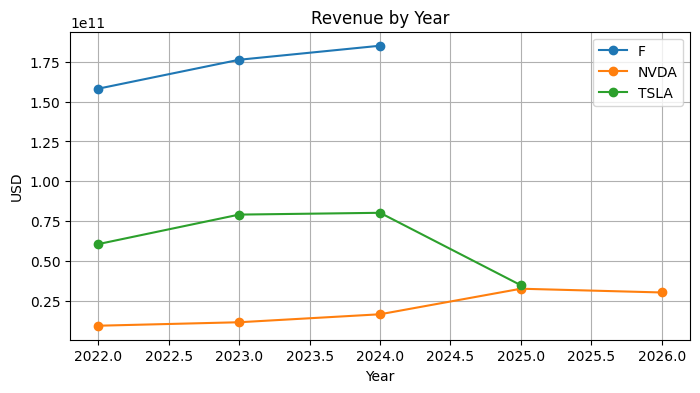

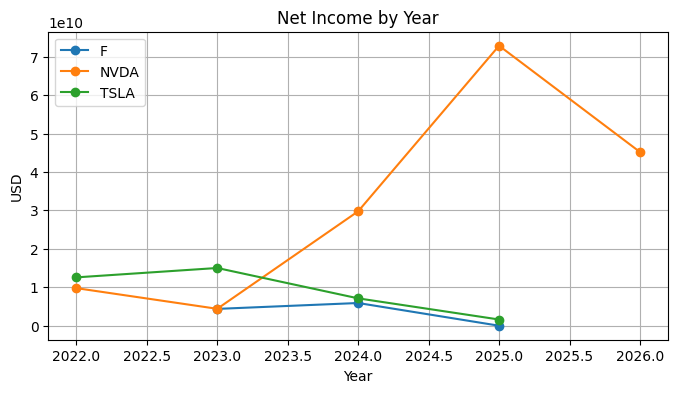

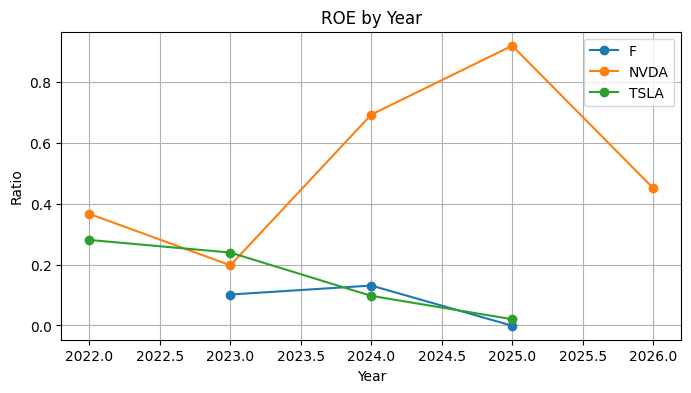

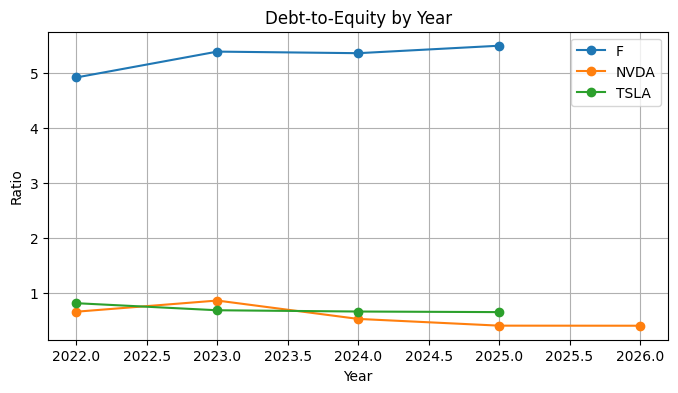

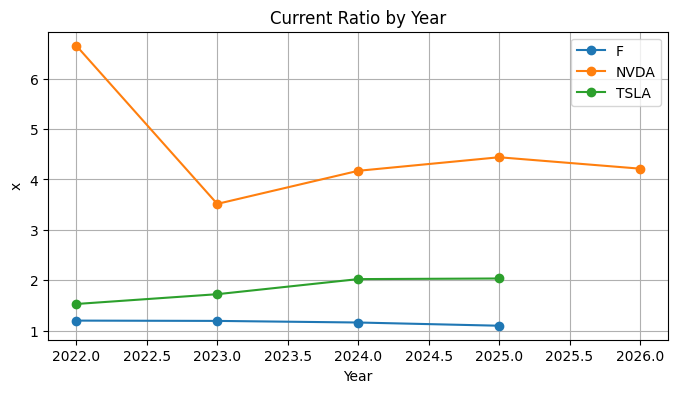

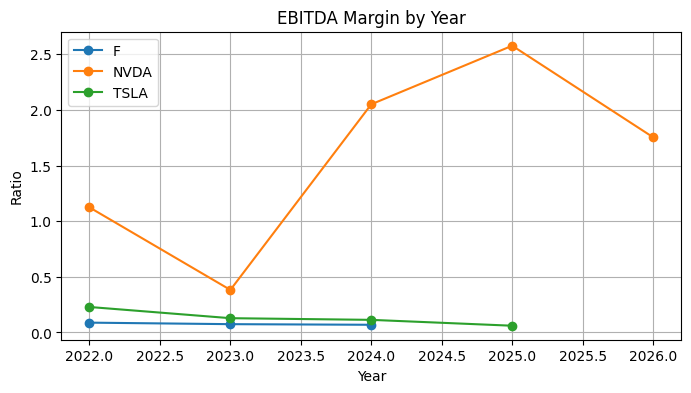

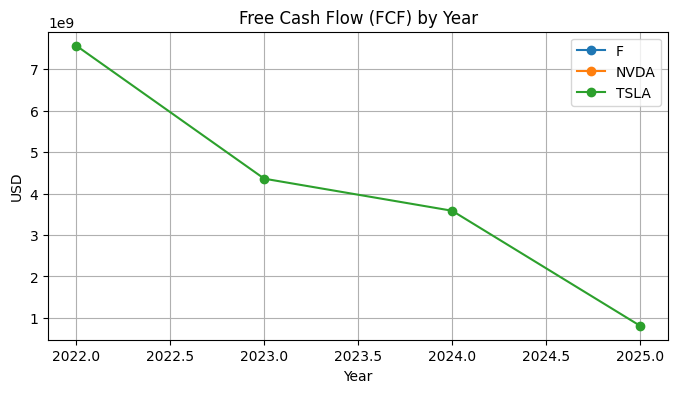

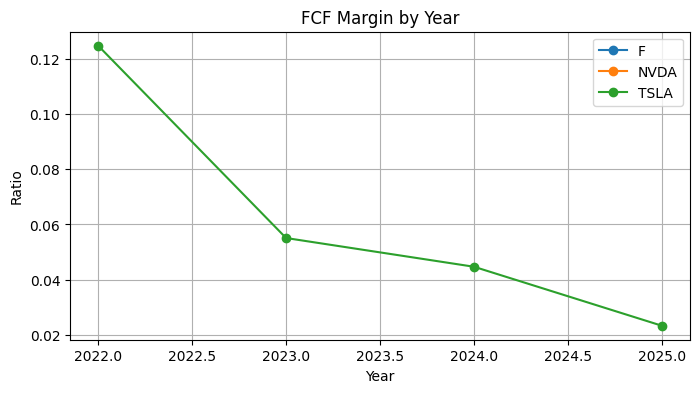

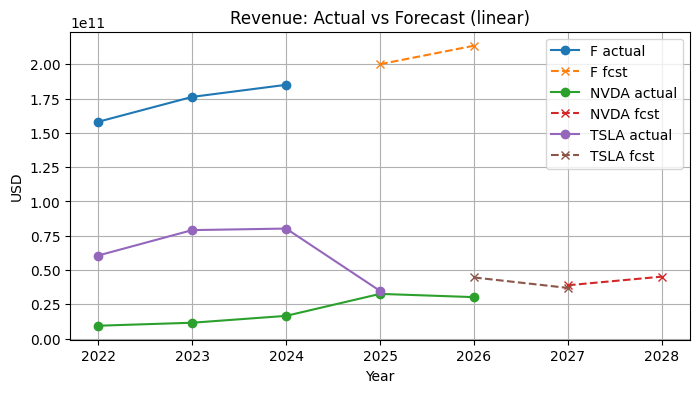

Saved: /content/sec_financials_clean.csv

Executive summary:

- **F** (2022→2025): 5Y Rev CAGR 8.19% | Avg ROE 7.73% | EBITDA margin nan% | FCF margin nan% | D/E 5.50 | PE ~-1303.6; next-year revenue forecast ≈ 200,015,000,000
- **NVDA** (2022→2026): 5Y Rev CAGR 33.84% | Avg ROE 52.53% | EBITDA margin 175.4% | FCF margin nan% | D/E 0.41 | PE ~96.7; next-year revenue forecast ≈ 38,933,500,000
- **TSLA** (2022→2025): 5Y Rev CAGR -16.88% | Avg ROE 15.95% | EBITDA margin 6.1% | FCF margin 2.3% | D/E 0.65 | PE ~881.5; next-year revenue forecast ≈ 44,615,500,000


In [20]:
# ===== Cell 6: Plots, export, summary =====

def plot_metric(df, metric, ylabel=None, title=None):
    for t in df["Ticker"].unique():
        sub = df[df["Ticker"]==t].sort_values("Year")
        plt.plot(sub["Year"], sub[metric], marker="o", label=t)
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel(ylabel or metric)
    if title: plt.title(title)
    plt.grid(True)
    plt.show()

def plot_revenue_with_forecast(df, fcst):
    for t in df["Ticker"].unique():
        sub = df[df["Ticker"]==t].sort_values("Year")
        plt.plot(sub["Year"], sub["Revenue"], marker="o", label=f"{t} actual")
        subf = fcst[fcst["Ticker"]==t]
        if len(subf):
            plt.plot(subf["Year"], subf["Revenue_Forecast"], marker="x", linestyle="--", label=f"{t} fcst")
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("USD")
    plt.title("Revenue: Actual vs Forecast (linear)")
    plt.grid(True)
    plt.show()

# Key charts
plot_metric(metrics_df, "Revenue", "USD", "Revenue by Year")
plot_metric(metrics_df, "NetIncome", "USD", "Net Income by Year")
plot_metric(metrics_df, "ROE", "Ratio", "ROE by Year")
plot_metric(metrics_df, "DebtToEquity", "Ratio", "Debt-to-Equity by Year")
plot_metric(metrics_df, "CurrentRatio", "x", "Current Ratio by Year")

# Advanced charts
plot_metric(metrics_df, "EBITDA_Margin", "Ratio", "EBITDA Margin by Year")
plot_metric(metrics_df, "FCF", "USD", "Free Cash Flow (FCF) by Year")
plot_metric(metrics_df, "FCF_Margin", "Ratio", "FCF Margin by Year")
plot_revenue_with_forecast(metrics_df, fcst_df)

# Export clean CSV for BI tools
out_csv = "/content/sec_financials_clean.csv"
metrics_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# Executive summary for README
def executive_summary(df: pd.DataFrame, pe_df: pd.DataFrame, fcst_df: pd.DataFrame) -> str:
    lines=[]
    for t in df["Ticker"].unique():
        sub = df[df["Ticker"]==t].sort_values("Year")
        y0,y1 = int(sub["Year"].min()), int(sub["Year"].max())
        rev_cagr = sub["RevenueCAGR_5Y"].dropna().iloc[-1] if sub["RevenueCAGR_5Y"].notna().any() else np.nan
        roe_avg = sub["ROE"].mean()
        fcf_margin_last = sub["FCF_Margin"].iloc[-1] if sub["FCF_Margin"].notna().any() else np.nan
        dte_last = sub["DebtToEquity"].iloc[-1]
        ebitda_margin_last = sub["EBITDA_Margin"].iloc[-1] if sub["EBITDA_Margin"].notna().any() else np.nan
        pe_row = pe_df[pe_df["Ticker"]==t]
        pe_str = f'PE ~{pe_row["PE"].iloc[0]:.1f}' if len(pe_row) and pd.notna(pe_row["PE"].iloc[0]) else "PE n/a"
        fcst = fcst_df[fcst_df["Ticker"]==t]
        fcst_note = ""
        if len(fcst):
            y_next = int(fcst["Year"].min())
            r_next = fcst[fcst["Year"]==y_next]["Revenue_Forecast"].iloc[0]
            fcst_note = f"; next-year revenue forecast ≈ {r_next:,.0f}"
        lines.append(
            f"- **{t}** ({y0}→{y1}): 5Y Rev CAGR {rev_cagr:.2%} | Avg ROE {roe_avg:.2%} | "
            f"EBITDA margin {ebitda_margin_last:.1%} | FCF margin {fcf_margin_last:.1%} | "
            f"D/E {dte_last:.2f} | {pe_str}{fcst_note}"
        )
    return "\n".join(lines)

print("\nExecutive summary:\n")
print(executive_summary(metrics_df, pe_df, fcst_df))
